Epoch 0, Loss: 0.4939432442188263
Epoch 100, Loss: 0.46602052450180054
Epoch 200, Loss: 0.44388219714164734
Epoch 300, Loss: 0.4356503188610077
Epoch 400, Loss: 0.446906715631485
Epoch 500, Loss: 0.4429907202720642
Epoch 600, Loss: 0.43280717730522156
Epoch 700, Loss: 0.427105188369751
Epoch 800, Loss: 0.43728408217430115
Epoch 900, Loss: 0.4243677854537964
Epoch 1000, Loss: 0.4066675305366516
Epoch 1100, Loss: 0.4159065783023834
Epoch 1200, Loss: 0.4071638286113739
Epoch 1300, Loss: 0.3259708881378174
Epoch 1400, Loss: 0.22310027480125427
Epoch 1500, Loss: 0.17962637543678284
Epoch 1600, Loss: 0.18115116655826569
Epoch 1700, Loss: 0.1731317788362503
Epoch 1800, Loss: 0.16982024908065796
Epoch 1900, Loss: 0.16954132914543152
Epoch 2000, Loss: 0.1649169772863388
Epoch 2100, Loss: 0.16200247406959534
Epoch 2200, Loss: 0.16175484657287598
Epoch 2300, Loss: 0.1597066968679428
Epoch 2400, Loss: 0.15848442912101746
Epoch 2500, Loss: 0.15403759479522705
Epoch 2600, Loss: 0.15639203786849976
E

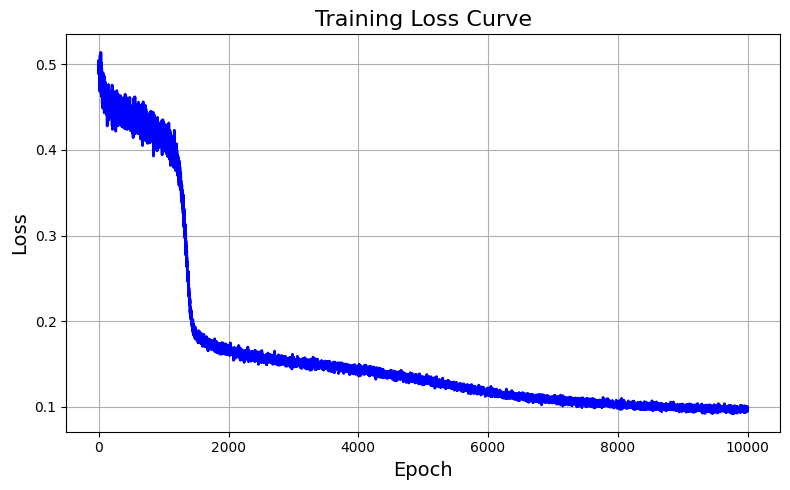

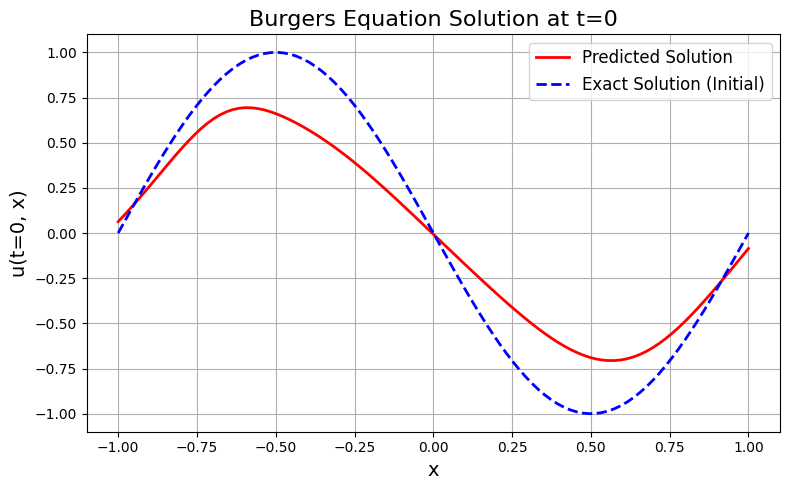

C:\Users\26921\AppData\Roaming\Python\Python37\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ValueError: cannot reshape array of size 10000 into shape (16,16)

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


# 绘制损失曲线
def plot_loss(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, color='blue', lw=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training Loss Curve', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 绘制数值解图像
def plot_solution(model):
    x = torch.linspace(-1, 1, 100).unsqueeze(1)
    t = torch.full((100, 1), 0.0)  # 在t=0时绘制解
    with torch.no_grad():
        u_pred = model(t, x).numpy()
    
    # 参考解 u(0,x) = -sin(πx)
    u_exact = -np.sin(np.pi * x.numpy())

    plt.figure(figsize=(8, 5))
    plt.plot(x.numpy(), u_pred, label='Predicted Solution', color='red', lw=2)
    plt.plot(x.numpy(), u_exact, label='Exact Solution (Initial)', color='blue', lw=2, linestyle='dashed')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('u(t=0, x)', fontsize=14)
    plt.title('Burgers Equation Solution at t=0', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# 绘制整个 (x, t) 平面的解
def plot_solution_3d(model):
    # 创建 (x, t) 网格
    x = torch.linspace(-1, 1, 100).unsqueeze(1)
    t = torch.linspace(0, 1, 100).unsqueeze(1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())
    
    # 将 X 和 T 拉平，方便模型预测
    x_flat = X.reshape(-1, 1)
    t_flat = T.reshape(-1, 1)

    with torch.no_grad():
        u_pred = model(t_flat, x_flat).numpy().reshape(16, 16)

    # 绘制三维曲面图
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), T.numpy(), u_pred, cmap='viridis')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('t', fontsize=12)
    ax.set_zlabel('u(t, x)', fontsize=12)
    ax.set_title('Solution of Burgers Equation on (x, t) Plane', fontsize=14)

    plt.show()

# 绘制二维等高线图
def plot_solution_contour(model):
    # 创建 (x, t) 网格
    x = torch.linspace(-1, 1, 100).unsqueeze(1)
    t = torch.linspace(0, 1, 100).unsqueeze(1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())

    # 将 X 和 T 拉平，方便模型预测
    x_flat = X.reshape(-1, 1)
    t_flat = T.reshape(-1, 1)

    with torch.no_grad():
        u_pred = model(t_flat, x_flat).numpy().reshape(16, 16)

    # 绘制二维等高线图
    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), T.numpy(), u_pred, 100, cmap='viridis')
    plt.colorbar(label='u(t, x)')
    
    plt.xlabel('x', fontsize=12)
    plt.ylabel('t', fontsize=12)
    plt.title('Contour Plot of Burgers Equation Solution', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    
# 定义网络结构
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(2, 16), nn.Tanh(),
            nn.Linear(16, 16), nn.Tanh(),
            nn.Linear(16, 16), nn.Tanh(),
            nn.Linear(16, 16), nn.Tanh(),
            nn.Linear(16, 16), nn.Tanh(),
            nn.Linear(16, 1)
        )
    
    def forward(self, t, x):
        u = self.layer(torch.cat([t, x], dim=1))
        return u

# 定义Burgers方程中的物理损失
def physics_loss(model, t, x):
    u = model(t, x)
    u_t = torch.autograd.grad(u, t, torch.ones_like(t), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(x), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(x), create_graph=True)[0]
    f = (u_t + u * u_x - (0.01 / torch.pi) * u_xx).pow(2).mean()
    return f

# 定义边界条件损失
def boundary_loss(model, t, x_left, x_right):
    u_left = model(t, x_left)
    u_right = model(t, x_right)
    return u_left.pow(2).mean() + u_right.pow(2).mean()

# 初始条件损失
def initial_loss(model, x):
    t_0 = torch.zeros_like(x)
    u_init = model(t_0, x)
    u_exact = -torch.sin(torch.pi * x)
    return (u_init - u_exact).pow(2).mean()

# 训练模型并记录损失
def train(model, optimizer, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # 随机采样 t 和 x，并确保 requires_grad=True
        t = torch.rand(3000, 1, requires_grad=True)
        x = torch.rand(3000, 1, requires_grad=True) * 2 - 1  # x ∈ [-1, 1]

        # 物理损失
        f_loss = physics_loss(model, t, x)

        # 边界条件损失
        t_bc = torch.rand(500, 1)
        x_left = -torch.ones(500, 1)
        x_right = torch.ones(500, 1)
        bc_loss = boundary_loss(model, t_bc, x_left, x_right)

        # 初始条件损失
        x_ic = torch.rand(1000, 1) * 2 - 1
        ic_loss = initial_loss(model, x_ic)

        # 总损失
        loss = f_loss + bc_loss + ic_loss
        loss.backward()
        optimizer.step()

        # 记录损失
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return losses

# 初始化模型和优化器
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 训练模型
losses = train(model, optimizer, num_epochs = 10000)

# 绘制训练损失曲线
plot_loss(losses)

# 绘制数值解图像
plot_solution(model)
plot_solution_3d(model)   # 三维曲面图
plot_solution_contour(model)   # 二维等高线图
